# Emission

Evaluates thermal emission implementation in sasktran v2 by comparing with radiance calculaton in sasktran v1 TIR engine.

Text(0, 0.5, '% Difference (v2 - v1) / v1 * 100')

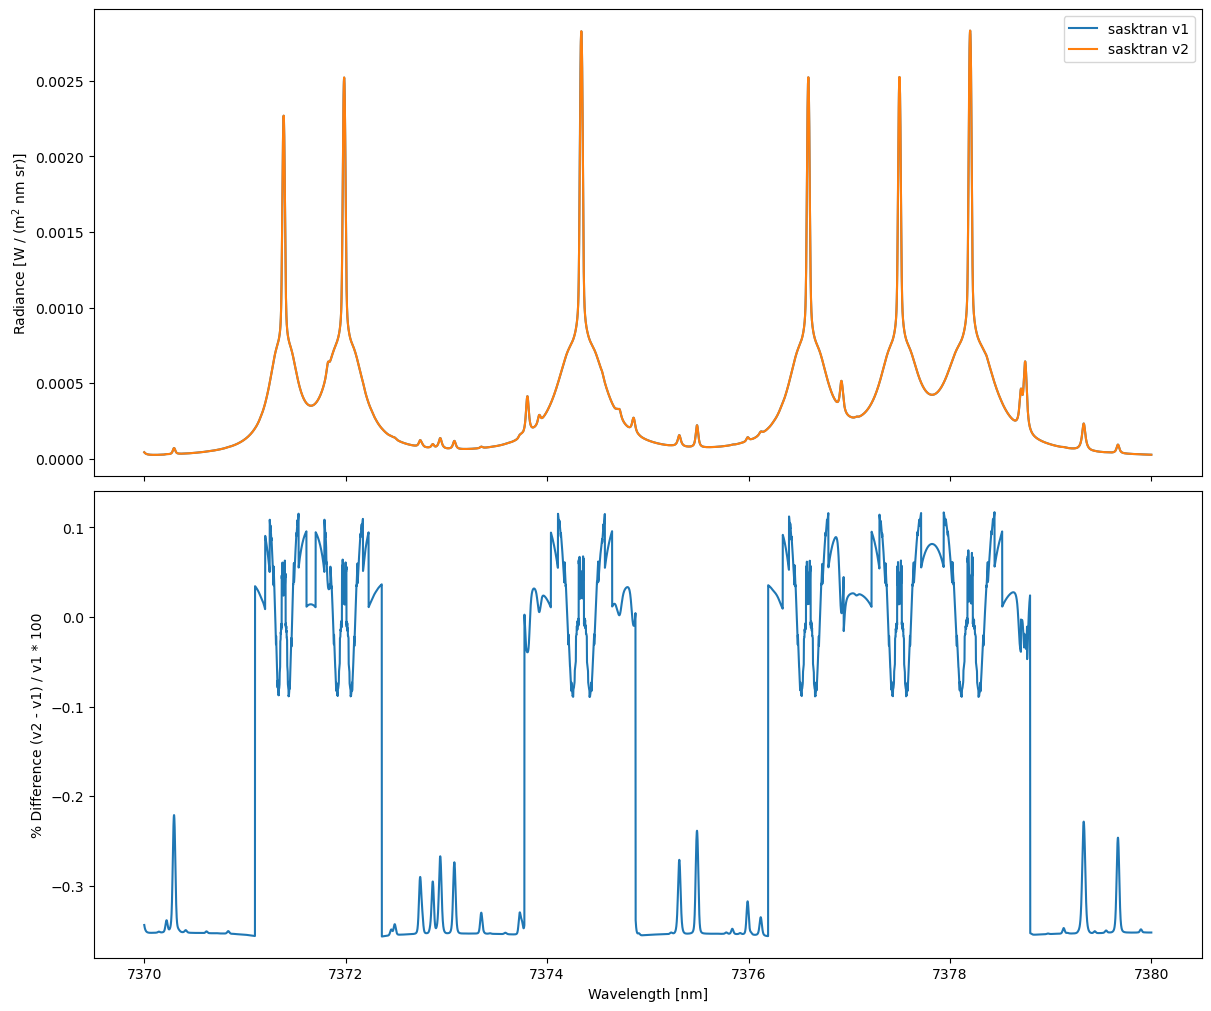

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sasktran as sk1
import sasktran2 as sk
from sasktran.tir.climatology import ClimatologyAtmosphericState, ClimatologySpecies
from sasktran.tir.engine import EngineTIR
from sasktran.tir.opticalproperty import HITRANChemicalTIR
from sasktran2.constants import PLANCK, SPEED_OF_LIGHT

# set up parameters used by both models
wavelengths = np.arange(7370, 7380, 0.001)
sza = 0
saa = 0
lat = 45
lon = 0
tanalts_km = [20]
mjd = 56300
locallook = 0.0
species = "CH4"
alt_grid = np.arange(0, 100001, 1000)
obs_alt_km = 600

# calculate extinction for sasktran2
ch4_xs = np.zeros([len(alt_grid), len(wavelengths)])
atmo_clim = ClimatologyAtmosphericState()
ch4_clim = ClimatologySpecies(species)
ch4_opt = HITRANChemicalTIR(species)
tem = atmo_clim.get_parameter('SKCLIMATOLOGY_TEMPERATURE_K', lat, lon, alt_grid, mjd)
ch4_nd = ch4_clim.get_parameter(f'SKCLIMATOLOGY_{species}_CM3', lat, lon, alt_grid, mjd)
for i in range(len(alt_grid)):
    ch4_xs[i] = ch4_opt.calculate_cross_sections(atmo_clim, lat, lon, alt_grid[i], mjd, wavelengths).absorption
ch4_ext = (ch4_nd * ch4_xs.T).T * 100.

# calculate radiance for sasktran1

geometry1 = sk1.VerticalImage()
geometry1.from_sza_saa(sza=sza, saa=saa, lat=lat, lon=lon, tanalts_km=tanalts_km, mjd=mjd, locallook=locallook, satalt_km=obs_alt_km)

atmosphere1 = sk1.Atmosphere()
atmosphere1.atmospheric_state = ClimatologyAtmosphericState()
atmosphere1[species] = sk1.Species(HITRANChemicalTIR(species), ClimatologySpecies(species))

engine1 = EngineTIR(geometry=geometry1, atmosphere=atmosphere1, wavelengths=wavelengths)
radiance1 = engine1.calculate_radiance()
radiance1 = radiance1 * PLANCK * SPEED_OF_LIGHT / wavelengths[:, np.newaxis] * 1e13  # convert from photon / (s sr cm2 nm) to W / (sr m2 nm)

# calculate radiance for sasktran2

config = sk.Config()
config.single_scatter_source = sk.SingleScatterSource.NoSource
config.emission_source = sk.EmissionSource.Standard

model_geometry = sk.Geometry1D(cos_sza=np.cos(np.deg2rad(sza)),
                                solar_azimuth=saa,
                                earth_radius_m=6372000,
                                altitude_grid_m=alt_grid,
                                interpolation_method=sk.InterpolationMethod.LinearInterpolation,
                                geometry_type=sk.GeometryType.Spherical)

viewing_geo = sk.ViewingGeometry()

for alt in tanalts_km:
    ray = sk.TangentAltitudeSolar(tangent_altitude_m=alt * 1000,
                                    relative_azimuth=saa,
                                    observer_altitude_m=obs_alt_km * 1000,
                                    cos_sza=np.cos(np.deg2rad(sza)))
    viewing_geo.add_ray(ray)

atmosphere = sk.Atmosphere(model_geometry, config, wavelengths_nm=wavelengths, calculate_derivatives=False)

# try to match atmosphere used in sasktran1
geo = atmosphere.model_geometry
atmosphere.pressure_pa = np.exp(
    np.interp(geo.altitudes(), atmo_clim.altitudes, np.log(atmo_clim._values['SKCLIMATOLOGY_PRESSURE_PA']), left=0, right=0)
)
atmosphere.temperature_k = np.interp(
    geo.altitudes(),
    atmo_clim.altitudes,
    atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'],
    left=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][0],
    right=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][-1]
)

atmosphere.storage.total_extinction = ch4_ext
atmosphere.storage.ssa[:] = 0
atmosphere['emission'] = sk.constituent.ThermalEmission()

engine = sk.Engine(config, model_geometry, viewing_geo)
output = engine.calculate_radiance(atmosphere)
radiance2 = output.isel(stokes=0).radiance.values
diff = radiance2 - radiance1
pdiff = diff / radiance1 * 100.

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, constrained_layout=True, figsize=(12, 10))
ax[0].plot(wavelengths, radiance1, label='sasktran v1')
ax[0].plot(wavelengths, radiance2, label='sasktran v2')
ax[1].plot(wavelengths, pdiff)
ax[0].set_ylabel('Radiance [W / (m$^2$ nm sr)]')
ax[0].legend()
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('% Difference (v2 - v1) / v1 * 100')


Text(0, 0.5, '% Difference (v2 - v1) / v1 * 100')

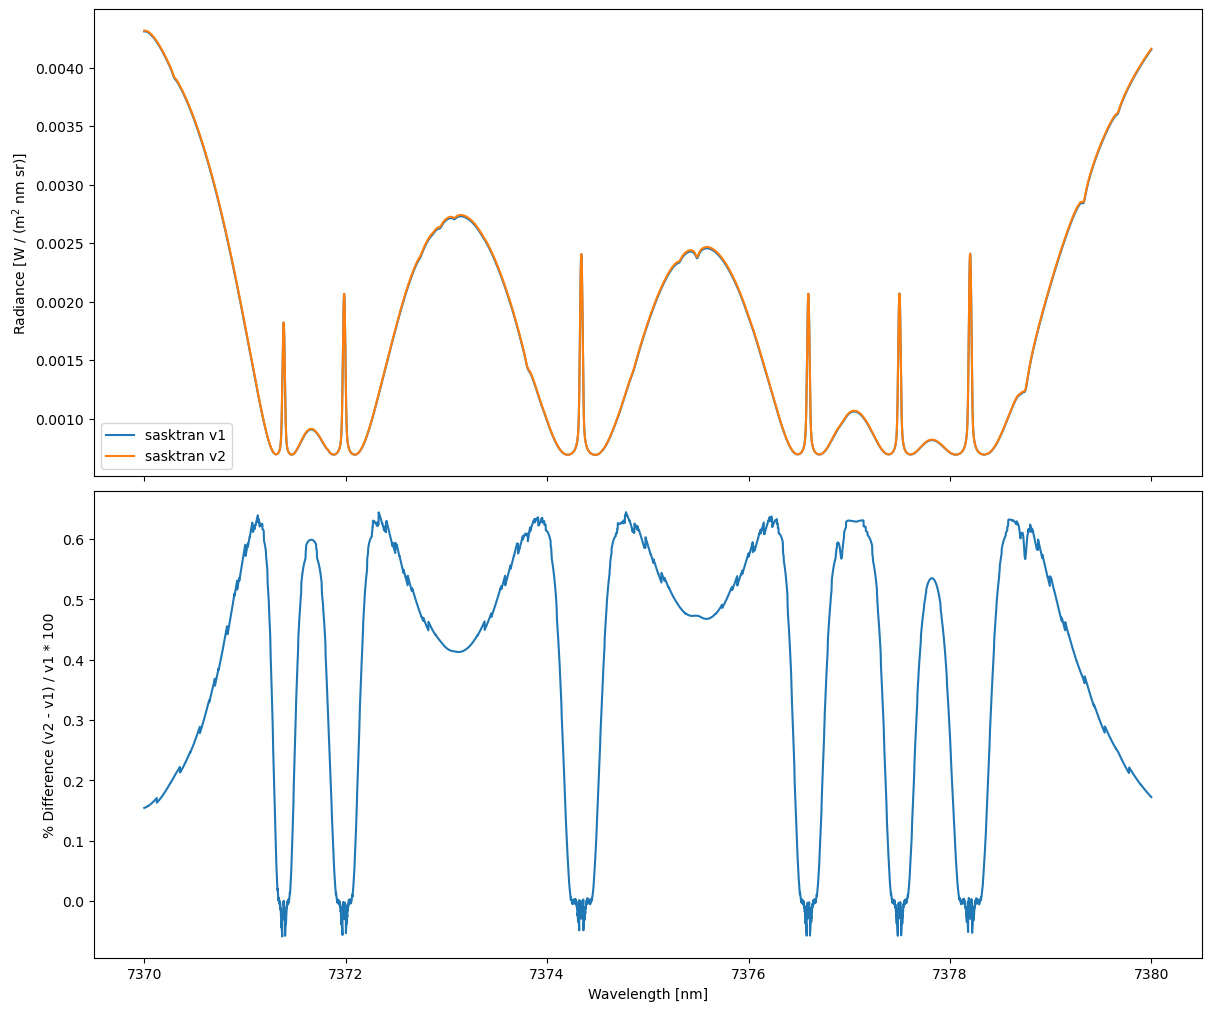

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sasktran as sk1
import sasktran2 as sk
from sasktran.tir.climatology import ClimatologyAtmosphericState, ClimatologySpecies
from sasktran.tir.engine import EngineTIR
from sasktran.tir.opticalproperty import HITRANChemicalTIR
from sasktran2.constants import PLANCK, SPEED_OF_LIGHT

# set up parameters used by both models
wavelengths = np.arange(7370, 7380, 0.001)
sza = 0
saa = 0
lat = 45
lon = 0
tanalts_km = [-50]
mjd = 56300
locallook = 0.0
species = "CH4"
alt_grid = np.arange(0, 100001, 1000)
obs_alt_km = 600
emissivity = 1.0

# calculate extinction for sasktran2
ch4_xs = np.zeros([len(alt_grid), len(wavelengths)])
atmo_clim = ClimatologyAtmosphericState()
ch4_clim = ClimatologySpecies(species)
ch4_opt = HITRANChemicalTIR(species)
tem = atmo_clim.get_parameter('SKCLIMATOLOGY_TEMPERATURE_K', lat, lon, alt_grid, mjd)
ch4_nd = ch4_clim.get_parameter(f'SKCLIMATOLOGY_{species}_CM3', lat, lon, alt_grid, mjd)
for i in range(len(alt_grid)):
    ch4_xs[i] = ch4_opt.calculate_cross_sections(atmo_clim, lat, lon, alt_grid[i], mjd, wavelengths).absorption
ch4_ext = (ch4_nd * ch4_xs.T).T * 100.

# calculate radiance for sasktran1

geometry1 = sk1.VerticalImage()
geometry1.from_sza_saa(sza=sza, saa=saa, lat=lat, lon=lon, tanalts_km=tanalts_km, mjd=mjd, locallook=locallook, satalt_km=obs_alt_km)

atmosphere1 = sk1.Atmosphere()
atmosphere1.atmospheric_state = ClimatologyAtmosphericState()
atmosphere1[species] = sk1.Species(HITRANChemicalTIR(species), ClimatologySpecies(species))

engine1 = EngineTIR(geometry=geometry1, atmosphere=atmosphere1, wavelengths=wavelengths)
engine1.ground_emissivity = emissivity
radiance1 = engine1.calculate_radiance()
radiance1 = radiance1 * PLANCK * SPEED_OF_LIGHT / wavelengths[:, np.newaxis] * 1e13  # convert from photon / (s sr cm2 nm) to W / (sr m2 nm)

# calculate radiance for sasktran2

config = sk.Config()
config.single_scatter_source = sk.SingleScatterSource.NoSource
config.emission_source = sk.EmissionSource.Standard

model_geometry = sk.Geometry1D(cos_sza=np.cos(np.deg2rad(sza)),
                                solar_azimuth=saa,
                                earth_radius_m=6372000,
                                altitude_grid_m=alt_grid,
                                interpolation_method=sk.InterpolationMethod.LinearInterpolation,
                                geometry_type=sk.GeometryType.Spherical)

viewing_geo = sk.ViewingGeometry()

for alt in tanalts_km:
    ray = sk.TangentAltitudeSolar(tangent_altitude_m=alt * 1000,
                                    relative_azimuth=saa,
                                    observer_altitude_m=obs_alt_km * 1000,
                                    cos_sza=np.cos(np.deg2rad(sza)))
    viewing_geo.add_ray(ray)

atmosphere = sk.Atmosphere(model_geometry, config, wavelengths_nm=wavelengths, calculate_derivatives=False)

# try to match atmosphere used in sasktran1
geo = atmosphere.model_geometry
atmosphere.pressure_pa = np.exp(
    np.interp(geo.altitudes(), atmo_clim.altitudes, np.log(atmo_clim._values['SKCLIMATOLOGY_PRESSURE_PA']), left=0, right=0)
)
atmosphere.temperature_k = np.interp(
    geo.altitudes(),
    atmo_clim.altitudes,
    atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'],
    left=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][0],
    right=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][-1]
)

atmosphere.storage.total_extinction = ch4_ext
atmosphere.storage.ssa[:] = 0
atmosphere['emission'] = sk.constituent.ThermalEmission()
atmosphere['surface_emission'] = sk.constituent.SurfaceThermalEmission(temperature_k=tem[0], emissivity=emissivity)

engine = sk.Engine(config, model_geometry, viewing_geo)
output = engine.calculate_radiance(atmosphere)
radiance2 = output.isel(stokes=0).radiance.values
diff = radiance2 - radiance1
pdiff = diff / radiance1 * 100.

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, constrained_layout=True, figsize=(12, 10))
ax[0].plot(wavelengths, radiance1, label='sasktran v1')
ax[0].plot(wavelengths, radiance2, label='sasktran v2')
ax[1].plot(wavelengths, pdiff)
ax[0].set_ylabel('Radiance [W / (m$^2$ nm sr)]')
ax[0].legend()
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('% Difference (v2 - v1) / v1 * 100')


Text(0, 0.5, '% Difference (v2 - v1) / v1 * 100')

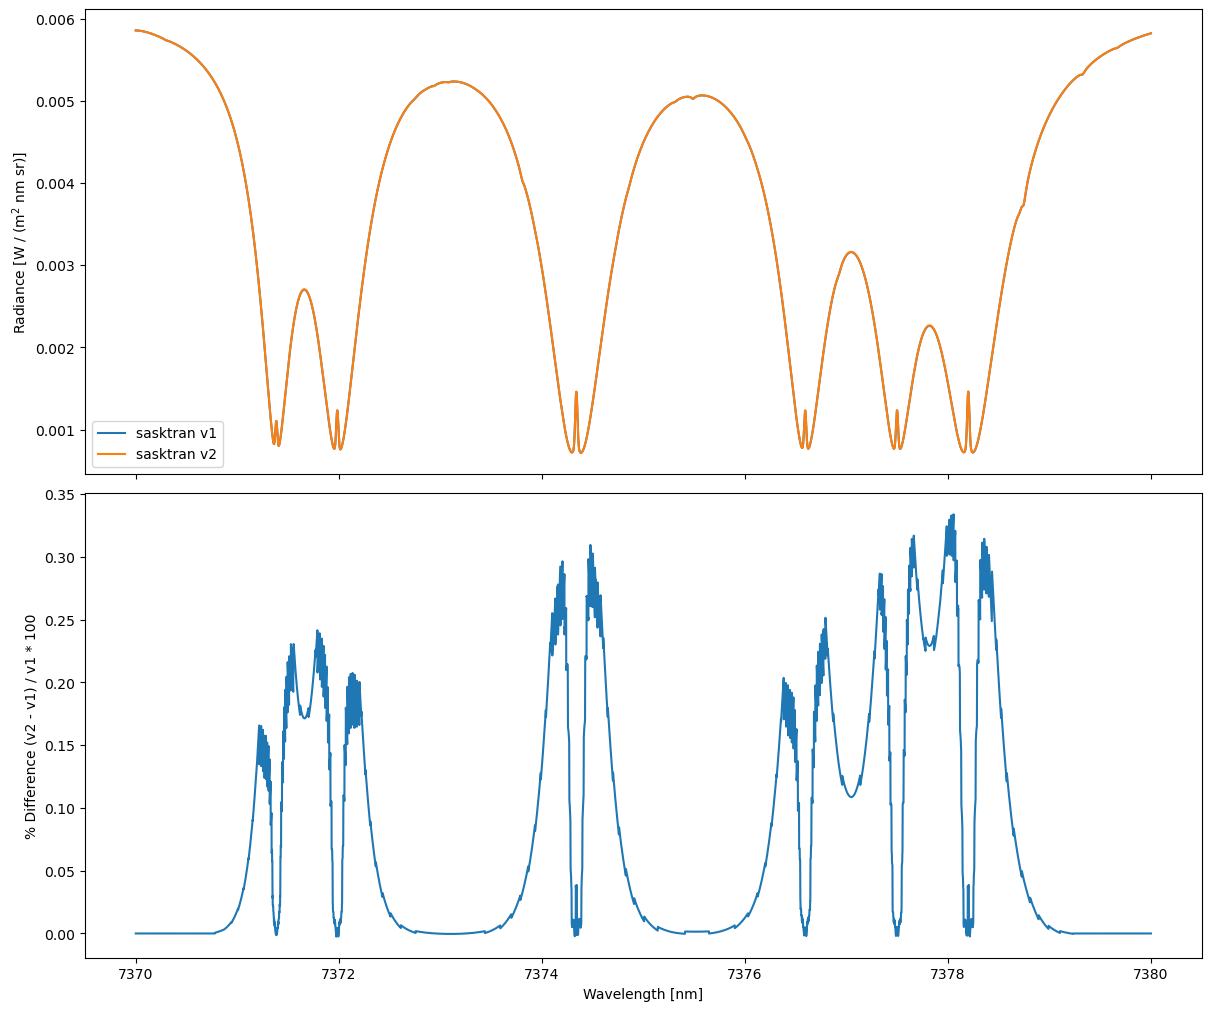

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import sasktran as sk1
import sasktran2 as sk
from sasktran.tir.climatology import ClimatologyAtmosphericState, ClimatologySpecies
from sasktran.tir.engine import EngineTIR
from sasktran.tir.opticalproperty import HITRANChemicalTIR
from sasktran2.constants import PLANCK, SPEED_OF_LIGHT

# set up parameters used by both models
wavelengths = np.arange(7370, 7380, 0.001)
sza = 0
saa = 0
lat = 45
lon = 0
tanalts_km = [-50]
mjd = 56300
locallook = 0.0
species = "CH4"
alt_grid = np.arange(0, 100001, 1000)
obs_alt_km = 600
emissivity = 1.0

# calculate extinction for sasktran2
ch4_xs = np.zeros([len(alt_grid), len(wavelengths)])
atmo_clim = ClimatologyAtmosphericState()
ch4_clim = ClimatologySpecies(species)
ch4_opt = HITRANChemicalTIR(species)
tem = atmo_clim.get_parameter('SKCLIMATOLOGY_TEMPERATURE_K', lat, lon, alt_grid, mjd)
ch4_nd = ch4_clim.get_parameter(f'SKCLIMATOLOGY_{species}_CM3', lat, lon, alt_grid, mjd)
for i in range(len(alt_grid)):
    ch4_xs[i] = ch4_opt.calculate_cross_sections(atmo_clim, lat, lon, alt_grid[i], mjd, wavelengths).absorption
ch4_ext = (ch4_nd * ch4_xs.T).T * 100.

# calculate radiance for sasktran1

# geometry1 = sk1.VerticalImage()
# geometry1.from_sza_saa(sza=sza, saa=saa, lat=lat, lon=lon, tanalts_km=tanalts_km, mjd=mjd, locallook=locallook, satalt_km=obs_alt_km)
geometry1 = sk1.NadirGeometry()
ref = sk1.Geodetic()
ref.from_lat_lon_alt(0, 0, 0)
geometry1.from_zeniths_and_azimuths(np.rad2deg(np.arccos(0.6)), 0, [56300], [np.rad2deg(np.arccos(0.8))], [0], [200000], [0, 0, 0, 56300])

atmosphere1 = sk1.Atmosphere()
atmosphere1.atmospheric_state = ClimatologyAtmosphericState()
atmosphere1[species] = sk1.Species(HITRANChemicalTIR(species), ClimatologySpecies(species))

engine1 = EngineTIR(geometry=geometry1, atmosphere=atmosphere1, wavelengths=wavelengths)
engine1.ground_emissivity = emissivity
radiance1 = engine1.calculate_radiance()
radiance1 = radiance1 * PLANCK * SPEED_OF_LIGHT / wavelengths[:, np.newaxis] * 1e13  # convert from photon / (s sr cm2 nm) to W / (sr m2 nm)

# calculate radiance for sasktran2

config = sk.Config()
config.single_scatter_source = sk.SingleScatterSource.NoSource
config.emission_source = sk.EmissionSource.Standard

model_geometry = sk.Geometry1D(cos_sza=0.6,
                                solar_azimuth=0,
                                earth_radius_m=6372000,
                                altitude_grid_m=alt_grid,
                                interpolation_method=sk.InterpolationMethod.LinearInterpolation,
                                geometry_type=sk.GeometryType.Spherical)

viewing_geo = sk.ViewingGeometry()

ray = sk.GroundViewingSolar(0.6, 0, 0.8, 200000)
viewing_geo.add_ray(ray)

atmosphere = sk.Atmosphere(model_geometry, config, wavelengths_nm=wavelengths, calculate_derivatives=False)

# try to match atmosphere used in sasktran1
geo = atmosphere.model_geometry
atmosphere.pressure_pa = np.exp(
    np.interp(geo.altitudes(), atmo_clim.altitudes, np.log(atmo_clim._values['SKCLIMATOLOGY_PRESSURE_PA']), left=0, right=0)
)
atmosphere.temperature_k = np.interp(
    geo.altitudes(),
    atmo_clim.altitudes,
    atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'],
    left=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][0],
    right=atmo_clim._values['SKCLIMATOLOGY_TEMPERATURE_K'][-1]
)

atmosphere.storage.total_extinction = ch4_ext
atmosphere.storage.ssa[:] = 0
atmosphere['emission'] = sk.constituent.ThermalEmission()
atmosphere['surface_emission'] = sk.constituent.SurfaceThermalEmission(temperature_k=tem[0], emissivity=emissivity)

engine = sk.Engine(config, model_geometry, viewing_geo)
output = engine.calculate_radiance(atmosphere)
radiance2 = output.isel(stokes=0).radiance.values
diff = radiance2 - radiance1
pdiff = diff / radiance1 * 100.

fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, constrained_layout=True, figsize=(12, 10))
ax[0].plot(wavelengths, radiance1, label='sasktran v1')
ax[0].plot(wavelengths, radiance2, label='sasktran v2')
ax[1].plot(wavelengths, pdiff)
ax[0].set_ylabel('Radiance [W / (m$^2$ nm sr)]')
ax[0].legend()
ax[1].set_xlabel('Wavelength [nm]')
ax[1].set_ylabel('% Difference (v2 - v1) / v1 * 100')
